In [14]:
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
import pickle
import timeit
import matplotlib.pyplot as plt
from itertools import chain
from scipy.spatial import distance
import itertools
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

In [1]:
# Takes a single row with 3D coordinates local radius/diameter and bodyid. Returns 14 points around it, without radius.
def spherical_sample_dataframe_row(array):
        results_array = np.empty((0,4),np.float64)
        point = np.array([array[0],array[1],array[2],array[4]])
        #if diameter_or_radius == "diameter":
        # If input is diameter, divide by 2 to get radius
        r = array[3]
        #elif diameter_or_radius == "radius":
        #    r = array[3]
        points_array = [point + np.array([0,0,r,0]),point + np.array([0,0,-r,0]),point + np.array([0,r,0,0]),point + np.array([0,-r,0,0]),
                        point + np.array([r,0,0,0]),point + np.array([-r,0,0,0]),point + np.array([r * 1/2,r * 1/2,r* np.sqrt(2)/2,0]),point + np.array([r * 1/2,-r* 1/2,r* np.sqrt(2)/2,0]),
                        point + np.array([-r* 1/2,r* 1/2,r* np.sqrt(2)/2,0]),point + np.array([-r* 1/2,-r* 1/2,r* np.sqrt(2)/2,0]),point + np.array([r* 1/2,r *1/2,-r* np.sqrt(2)/2,0]),
                        point + np.array([r* 1/2,-r* 1/2,-r* np.sqrt(2)/2,0]), point + np.array([-r* 1/2,r* 1/2,-r* np.sqrt(2)/2,0]),point + np.array([-r* 1/2,-r* 1/2,-r* np.sqrt(2)/2,0])
                                    ]
        results_array =   np.append(results_array,np.array(points_array),axis=0)
        return np.array(results_array).astype(np.float64)


In [9]:
def dataframe_to_bodyid_kd_tree(points_df):
    start_total = timeit.default_timer()
    points_numpy = points_df.to_numpy()
    points_numpy = np.apply_along_axis(spherical_sample_dataframe_row,1,points_numpy )
    points_numpy = np.concatenate(points_numpy)
    body_id_array, occurence_start_array = np.unique(points_numpy[:,3],return_index = True)
    occurence_start_array = np.sort(occurence_start_array)
    big_tree = KDTree(points_numpy[:,:3],compact_nodes=True,balanced_tree=True,leafsize = 400)
    end_total = timeit.default_timer()
    print('KD Tree construction time:',end_total-start_total)
    return big_tree,body_id_array,occurence_start_array,points_numpy

In [3]:
def query_tree_with_neuron_bodyid(big_tree,occurence_start_array,body_id_array,points_numpy,radius):
    metagraph_edgelist_dictionary = {}
    for i in range(0,occurence_start_array.shape[0]):
            body_id = int(points_numpy[:,3][occurence_start_array[i]])
            if i <occurence_start_array.shape[0]-1:
                interval_start_index = occurence_start_array[i]
                interval_end_index = occurence_start_array[i+1]
                results = big_tree.query_ball_point(points_numpy[interval_start_index :interval_end_index, :3], r = radius,return_sorted=True)
                results_array = np.fromiter(itertools.chain.from_iterable(results), np.int64)
            else:
                interval_start_index = occurence_start_array[i]
                results = big_tree.query_ball_point(points_numpy[interval_start_index :, :3], r = radius,return_sorted=True)
                results_array = np.fromiter(itertools.chain.from_iterable(results), np.int64)
            unique_results = np.unique(results_array)
            metagraph_edgelist_dictionary[body_id] = []
            # Check for each neuron if it's in the neighborhood
            for j in range(0,occurence_start_array.shape[0]):
                    # Remove the neuron we are looking at 
                    body_id_neighbor =  int(points_numpy[:,3][occurence_start_array[j]])
                    if body_id != body_id_neighbor:
                        if j <occurence_start_array.shape[0]-1:
                            interval_start_index = occurence_start_array[j]
                            interval_end_index = occurence_start_array[j+1]
                            #print('BodyID of the testing neighbor neuron:',body_id_neighbor)
                            #print('Starting index of the neuron in the large array:',interval_start_index)
                            #print('Ending index of the neuron in the large array:',interval_end_index)
                            mask_inverted = np.logical_and((interval_start_index  <= unique_results),(unique_results < interval_end_index))
                        else:
                            interval_start_index = occurence_start_array[-1]
                            #print('BodyID of the testing neighbor neuron:',body_id_neighbor)
                            #print('Starting index of the neuron in the large array:',interval_start_index)
                            #print('Ending index of the neuron in the large array:',)
                            mask_inverted = np.logical_and((interval_start_index  <= unique_results),True)
                        statement = mask_inverted.any()
                        #If the neighbor with this bodyid is present in the neighborhood
                        if mask_inverted.any():
                            metagraph_edgelist_dictionary[body_id].append(body_id_neighbor)
                        mask = np.logical_not(mask_inverted) 
                        unique_results = unique_results[mask]
                        if unique_results.size == 0: #If array is emptied, stop the process
                            break
    return metagraph_edgelist_dictionary

## Calculting minimum distances by using metagraphs

In [17]:
def min_distance_pdf_metagraph(metagraph_edgelist_dictionary,points_numpy,body_id_array,occurence_start_array):
    metagraph_min_distances = {}
    min_distances_all_list = []
    count = 0
    for key in list(metagraph_edgelist_dictionary.keys()):
        print('Neuron count:',count,'from total of:',len(metagraph_edgelist_dictionary))
        node_1_bodyid = key
        metagraph_min_distances[key] = {}
        node_1_bodyid_array_index = np.where(body_id_array == node_1_bodyid)
        index_1_start = occurence_start_array[node_1_bodyid_array_index][0]
        if  node_1_bodyid_array_index[0]  < len(body_id_array)-1:
            index_1_end =  occurence_start_array[node_1_bodyid_array_index[0]+1][0]
            point_list_1 =  points_numpy[index_1_start:index_1_end]
        else:
            point_list_1 =  points_numpy[index_1_start:]
        point_list_1 = point_list_1[:,:3]
        neighbor_count = 0
        for value_index in range(0,len(metagraph_edgelist_dictionary[key])):
            #print('Neighbor count:',neighbor_count,"from total of:",len(metagraph_edgelist_dictionary[key]))
            node_2_bodyid = metagraph_edgelist_dictionary[key][value_index]
            metagraph_min_distances[key][value_index] = {}
            node_2_bodyid_array_index = np.where(body_id_array == node_2_bodyid)
            index_2_start = occurence_start_array[node_2_bodyid_array_index][0]
            if  node_2_bodyid_array_index[0] < len(body_id_array)-1:
                index_2_end =  occurence_start_array[node_2_bodyid_array_index[0]+1][0]
                point_list_2 =  points_numpy[index_2_start:index_2_end]
            else:
                point_list_2 =  points_numpy[index_2_start:]
            point_list_2 = point_list_2[:,:3]
            
            if len(point_list_1) < 5000 or len(point_list_2) < 5000:

                min_distance = np.min(distance.cdist(point_list_1,point_list_2).flatten('C'))
            
            else:
                query_distance_list = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60, 70, 80, 90, 100, 150,200]
                for r in query_distance_list:
                    #print(r)
                    kd_tree1 = KDTree(point_list_1)
                    kd_tree2 = KDTree(point_list_2)
                    indexes = kd_tree1.query_ball_tree(kd_tree2, r=r)

                    index_list = []
                    for i in range(0,len(indexes)):
                        if len(indexes[i]) >= 1:
                            index_list.append(i)
                    if len(index_list) == 0:
                        pass
                    min_distance_candidates = []
                    for i in index_list:
                        for j in indexes[i]:
                            min_distance_candidates.append(distance.euclidean(point_list_1[i],point_list_2[j]))
                    #print(min_distance_candidates)
                    if r == 200 and len(min_distance_candidates) == 0:
                        #print('Minimum distance is larger than 200')
                        min_distance_candidates.append(201)
                    if len(min_distance_candidates) > 0:
                        #print('Break')
                        break
                min_distance = np.min(min_distance_candidates)


            metagraph_min_distances[key][value_index] = min_distance
            min_distances_all_list.append(min_distance)
            neighbor_count += 1
            if min_distance > 200:
                print( node_1_bodyid, node_2_bodyid)
                print(min_distance)
        count += 1
        a_file = open(region+"_minimum_distance_list.pkl", "wb")
        pickle.dump(min_distances_all_list, a_file)
        b_file = open(region+"_min_distance_metagraph.pkl", "wb")
        pickle.dump(metagraph_min_distances, a_file)
    return min_distances_all_list,metagraph_min_distances

In [ ]:
region = "ME(R)"
radius_list =  [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60, 70, 80, 90, 100, 150,200]

biggest_intersection_threshold = np.max(radius_list)
points_df = pd.read_csv('neuron_regions_points/' + 'ME(R)' + '_3721.csv',usecols=['x','y','z','radius','bodyId'])
#points_df =  test_df[0:100000].copy()

infile = open('metagraphs/' + region +'_edge_dict_spherical_'+str(200)+'.pkl','rb')
metagraph_edgelist_dictionary = pickle.load(infile)
print('Creating spherical trees')
big_tree,bodyid_array,occurence_start_arraay,points_numpy = dataframe_to_bodyid_kd_tree(points_df)
#metagraph_edgelist_dictionary = query_tree_with_neuron_bodyid(big_tree,occurence_start_array,bodyid_array,points_numpy,200)
min_distances_all_list,metagraph_min_distances = min_distance_pdf_metagraph(metagraph_edgelist_dictionary,points_numpy,bodyid_array,occurence_start_array)



a_file = open(region+"_minimum_distance_list.pkl", "wb")
pickle.dump(min_distances_all_list, a_file)
b_file = open(region+"_min_distance_metagraph.pkl", "wb")
pickle.dump(metagraph_min_distances, a_file)

Creating spherical trees
KD Tree construction time: 69.9692043
Neuron count: 0 from total of: 2972
Neuron count: 1 from total of: 2972
Neuron count: 2 from total of: 2972
Neuron count: 3 from total of: 2972
Neuron count: 4 from total of: 2972
Neuron count: 5 from total of: 2972
Neuron count: 6 from total of: 2972
Neuron count: 7 from total of: 2972
Neuron count: 8 from total of: 2972
Neuron count: 9 from total of: 2972
Neuron count: 10 from total of: 2972
Neuron count: 11 from total of: 2972
Neuron count: 12 from total of: 2972
Neuron count: 13 from total of: 2972
Neuron count: 14 from total of: 2972
Neuron count: 15 from total of: 2972
Neuron count: 16 from total of: 2972
Neuron count: 17 from total of: 2972
Neuron count: 18 from total of: 2972


In [ ]:
for n in new_lines_number_list:
    plt.figure(figsize=(12,8))
    plt.hist(min_distances_all_list,alpha=0.5,label=' ME(R)',bins = 20)
    plt.xlabel('Minimum distance')
    plt.ylabel('Count')
    plt.title('Number of new lines added: ' + str(n))
    plt.legend()


In [115]:
body_id_1 = 2128109571 
body_id_2 = 1472676490
point_df_1 = points_df[points_df['bodyId'] == body_id_1]
point_df_2 = points_df[points_df['bodyId'] == body_id_2]

In [122]:
np_1 = point_df_1.to_numpy()[:,0:3]
np_2 = point_df_2.to_numpy()[:,0:3]

In [2]:
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
import pickle
import timeit
import matplotlib.pyplot as plt
from itertools import chain
from scipy.spatial import distance
import itertools


# Takes a single row with 3D coordinates local radius/diameter and bodyid. Returns 14 points around it, without radius.
def spherical_sample_dataframe_row(array):
        results_array = np.empty((0,4),np.float64)
        point = np.array([array[0],array[1],array[2],array[4]])
        #if diameter_or_radius == "diameter":
        # If input is diameter, divide by 2 to get radius
        r = array[3]
        #elif diameter_or_radius == "radius":
        #    r = array[3]
        points_array = [point + np.array([0,0,r,0]),point + np.array([0,0,-r,0]),point + np.array([0,r,0,0]),point + np.array([0,-r,0,0]),
                        point + np.array([r,0,0,0]),point + np.array([-r,0,0,0]),point + np.array([r * 1/2,r * 1/2,r* np.sqrt(2)/2,0]),point + np.array([r * 1/2,-r* 1/2,r* np.sqrt(2)/2,0]),
                        point + np.array([-r* 1/2,r* 1/2,r* np.sqrt(2)/2,0]),point + np.array([-r* 1/2,-r* 1/2,r* np.sqrt(2)/2,0]),point + np.array([r* 1/2,r *1/2,-r* np.sqrt(2)/2,0]),
                        point + np.array([r* 1/2,-r* 1/2,-r* np.sqrt(2)/2,0]), point + np.array([-r* 1/2,r* 1/2,-r* np.sqrt(2)/2,0]),point + np.array([-r* 1/2,-r* 1/2,-r* np.sqrt(2)/2,0])
                                    ]
        results_array =   np.append(results_array,np.array(points_array),axis=0)
        return np.array(results_array).astype(np.float64)

def dataframe_to_bodyid_kd_tree(points_df):
    start_total = timeit.default_timer()
    points_numpy = points_df.to_numpy()
    points_numpy = np.apply_along_axis(spherical_sample_dataframe_row,1,points_numpy )
    points_numpy = np.concatenate(points_numpy)
    body_id_array, occurence_start_array = np.unique(points_numpy[:,3],return_index = True)
    occurence_start_array = np.sort(occurence_start_array)
    big_tree = KDTree(points_numpy[:,:3],compact_nodes=True,balanced_tree=True,leafsize = 400)
    end_total = timeit.default_timer()
    print('KD Tree construction time:',end_total-start_total)
    return big_tree,body_id_array,occurence_start_array,points_numpy

def query_tree_with_neuron_bodyid(big_tree,occurence_start_array,body_id_array,points_numpy,radius):
    metagraph_edgelist_dictionary = {}
    for i in range(0,occurence_start_array.shape[0]):
            body_id = int(points_numpy[:,3][occurence_start_array[i]])
            if i <occurence_start_array.shape[0]-1:
                interval_start_index = occurence_start_array[i]
                interval_end_index = occurence_start_array[i+1]
                results = big_tree.query_ball_point(points_numpy[interval_start_index :interval_end_index, :3], r = radius,return_sorted=True)
                results_array = np.fromiter(itertools.chain.from_iterable(results), np.int64)
            else:
                interval_start_index = occurence_start_array[i]
                results = big_tree.query_ball_point(points_numpy[interval_start_index :, :3], r = radius,return_sorted=True)
                results_array = np.fromiter(itertools.chain.from_iterable(results), np.int64)
            unique_results = np.unique(results_array)
            metagraph_edgelist_dictionary[body_id] = []
            # Check for each neuron if it's in the neighborhood
            for j in range(0,occurence_start_array.shape[0]):
                    # Remove the neuron we are looking at 
                    body_id_neighbor =  int(points_numpy[:,3][occurence_start_array[j]])
                    if body_id != body_id_neighbor:
                        if j <occurence_start_array.shape[0]-1:
                            interval_start_index = occurence_start_array[j]
                            interval_end_index = occurence_start_array[j+1]
                            #print('BodyID of the testing neighbor neuron:',body_id_neighbor)
                            #print('Starting index of the neuron in the large array:',interval_start_index)
                            #print('Ending index of the neuron in the large array:',interval_end_index)
                            mask_inverted = np.logical_and((interval_start_index  <= unique_results),(unique_results < interval_end_index))
                        else:
                            interval_start_index = occurence_start_array[-1]
                            #print('BodyID of the testing neighbor neuron:',body_id_neighbor)
                            #print('Starting index of the neuron in the large array:',interval_start_index)
                            #print('Ending index of the neuron in the large array:',)
                            mask_inverted = np.logical_and((interval_start_index  <= unique_results),True)
                        statement = mask_inverted.any()
                        #If the neighbor with this bodyid is present in the neighborhood
                        if mask_inverted.any():
                            metagraph_edgelist_dictionary[body_id].append(body_id_neighbor)
                        mask = np.logical_not(mask_inverted) 
                        unique_results = unique_results[mask]
                        if unique_results.size == 0: #If array is emptied, stop the process
                            break

                            
region = "ME(R)"
radius_list =  [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60, 70, 80, 90, 100, 150,200]

biggest_intersection_threshold = np.max(radius_list)
points_df = pd.read_csv(region+ '_3721.csv',usecols=['x','y','z','radius','bodyId'])
#points_df =  test_df[0:100000].copy()

infile = open( region +'_edge_dict_spherical_'+str(200)+'.pkl','rb')
metagraph_edgelist_dictionary = pickle.load(infile)
print('Creating spherical trees')
big_tree,body_id_array,occurence_start_array,points_numpy = dataframe_to_bodyid_kd_tree(points_df)
#metagraph_edgelist_dictionary = query_tree_with_neuron_bodyid(big_tree,occurence_start_array,bodyid_array,points_numpy,200)


metagraph_min_distances = {}
min_distances_all_list = []
count = 0
for key in list(metagraph_edgelist_dictionary.keys()):
    print('Neuron count:',count,'from total of:',len(metagraph_edgelist_dictionary))
    node_1_bodyid = key
    metagraph_min_distances[key] = {}
    node_1_bodyid_array_index = np.where(body_id_array == node_1_bodyid)
    index_1_start = occurence_start_array[node_1_bodyid_array_index][0]
    if  node_1_bodyid_array_index[0]  < len(body_id_array)-1:
        index_1_end =  occurence_start_array[node_1_bodyid_array_index[0]+1][0]
        point_list_1 =  points_numpy[index_1_start:index_1_end]
    else:
        point_list_1 =  points_numpy[index_1_start:]
    point_list_1 = point_list_1[:,:3]
    neighbor_count = 0
    for value_index in range(0,len(metagraph_edgelist_dictionary[key])):
        #print('Neighbor count:',neighbor_count,"from total of:",len(metagraph_edgelist_dictionary[key]))
        node_2_bodyid = metagraph_edgelist_dictionary[key][value_index]
        metagraph_min_distances[key][value_index] = {}
        node_2_bodyid_array_index = np.where(body_id_array == node_2_bodyid)
        index_2_start = occurence_start_array[node_2_bodyid_array_index][0]
        if  node_2_bodyid_array_index[0] < len(body_id_array)-1:
            index_2_end =  occurence_start_array[node_2_bodyid_array_index[0]+1][0]
            point_list_2 =  points_numpy[index_2_start:index_2_end]
        else:
            point_list_2 =  points_numpy[index_2_start:]
        point_list_2 = point_list_2[:,:3]

        if len(point_list_1) < 5000 or len(point_list_2) < 5000:

            min_distance = np.min(distance.cdist(point_list_1,point_list_2).flatten('C'))

        else:
            query_distance_list = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60, 70, 80, 90, 100, 150,200]
            for r in query_distance_list:
                #print(r)
                kd_tree1 = KDTree(point_list_1)
                kd_tree2 = KDTree(point_list_2)
                indexes = kd_tree1.query_ball_tree(kd_tree2, r=r)

                index_list = []
                for i in range(0,len(indexes)):
                    if len(indexes[i]) >= 1:
                        index_list.append(i)
                if len(index_list) == 0:
                    pass
                min_distance_candidates = []
                for i in index_list:
                    for j in indexes[i]:
                        min_distance_candidates.append(distance.euclidean(point_list_1[i],point_list_2[j]))
                #print(min_distance_candidates)
                if r == 200 and len(min_distance_candidates) == 0:
                    #print('Minimum distance is larger than 200')
                    min_distance_candidates.append(201)
                if len(min_distance_candidates) > 0:
                    #print('Break')
                    break
            min_distance = np.min(min_distance_candidates)


        metagraph_min_distances[key][value_index] = min_distance
        min_distances_all_list.append(min_distance)
        neighbor_count += 1
        if min_distance > 200:
            print( node_1_bodyid, node_2_bodyid)
            print(min_distance)
    count += 1
    a_file = open(region+"_minimum_distance_list.pkl", "wb")
    pickle.dump(min_distances_all_list, a_file)
    b_file = open(region+"_min_distance_metagraph.pkl", "wb")
    pickle.dump(metagraph_min_distances, a_file)


Creating spherical trees
KD Tree construction time: 73.68749229999999
Neuron count: 0 from total of: 2972


KeyboardInterrupt: 

In [10]:
import seaborn as sns
import scipy
region = "ME(R)"
infile = open(region+"_minimum_distance_list.pkl", "rb")
minimum_distance_pdf = pickle.load(infile)


Text(0.5, 0, 'Minimum distance between two neurons')

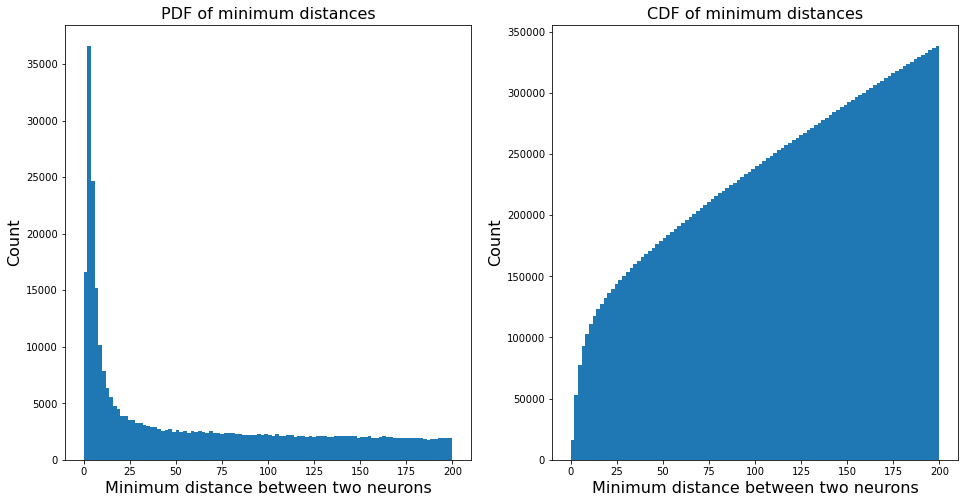

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(minimum_distance_pdf,bins=100)
plt.ylabel('Count')
plt.xlabel('Minimum distance between two neurons')
plt.title('PDF of minimum distances')
plt.subplot(1,2,2)
plt.hist(minimum_distance_pdf,cumulative=True,bins=100)
plt.title('CDF of minimum distances')
plt.ylabel('Count')
plt.xlabel('Minimum distance between two neurons')

Text(0.5, 0, 'Minimum distance between two neurons')

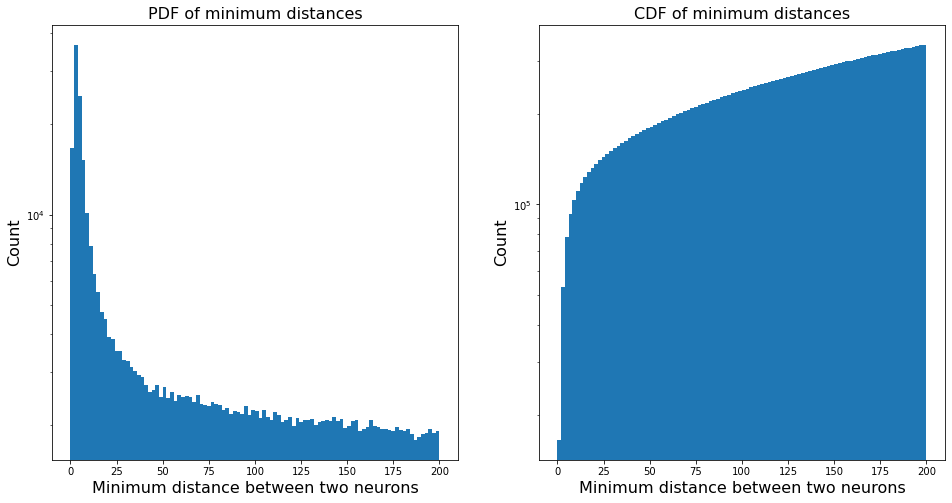

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(minimum_distance_pdf,bins=100)
plt.ylabel('Count')
plt.xlabel('Minimum distance between two neurons')
plt.yscale('log')
plt.title('PDF of minimum distances')
plt.subplot(1,2,2)
plt.hist(minimum_distance_pdf,cumulative=True,bins=100)
plt.title('CDF of minimum distances')
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('Minimum distance between two neurons')